# Notebook to infer reliable time horizon

To run this notebook you need to create and activate the following conda environment:

```
conda create --name score_eval -c conda-forge -c defaults numpy pandas matplotlib seaborn scipy scikit-learn ipython ipykernel -y
conda activate score_eval
pip install -e .
```


## Setup

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

from src.utils_eval_score import (
    _get_ordinal_suffix,
    _get_step_n_indicator,
    _group_samples_prior_to_cutoff,
    _plot_score_after_nth_abx_exposure,
    get_cutoff_value_sample_sizes,
    get_scores_n_abx_info,
)
from src.utils_t_horizon import (
    display_two_distributions,
    enrich_scores,
    plot_cutoff_date_distribution,
    sample_from_each_group,
    select_last_score_per_host_per_bin,
    transform_cutoff_scores,
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)
# avg. number of days per month
DAYS_PER_MONTH = 30.437

USER input: define the inferred model and linked datasets to evaluate here:

In [2]:
#### USER INPUT START

# model id
model_id = 57
# name of the model
model_name = f"saved_models_microbial_novel_alpha_div2/id-{model_id}"
# which model version to evaluate: "best" or "last"
point_to_evaluate = "best"

# name of feature dataset used for model
# ft_name = "ft_vat19_anomaly_v20240806_entero_genus"
ft_name = "ft_vat19_anomaly_v20240806_entero_family"
# name of abx time-series used for model
abx_ts_name = "ts_vat19_abx_v20240806"

# limit evaluation to time range up to this many months (if None no limit is set
# and all scores are evaluated)
limit_months = 24.0

# whether to group samples prior to cutoff in analysis
group_samples = True

# how many samples prior and after cutoff to consider
min_samples = -3.0
max_samples = 12.0

# whether to filter noabx score samples by having at least 1 obs prior to cutoff
no_filter = True

# whether to have max. resolution of 0.5 months or not
max_resolution = False

# scaling factor options:
scaling_factors_used = True

# if scaling_factors_used is True, then the following options are required:
# non-centered = "nc_std" or centered = "std"
stddev_type = "nc_std"
# moving average window size: 30 or 10
moving_avg = 10
# whether to remove duplicates: "--RD-True" or include them "--RD-False"
duplicates = "--RD-True"
# using lower bound of 1 for SFs: "lower_bound-1" or ""
lower_bound = ""

#### USER INPUT END

## Prepare data

In [3]:
base_path = f"../data/{model_name}/anomaly_detection/"

res_n_group = f"g{str(group_samples)[0]}_maxres{str(max_resolution)[0]}"

if scaling_factors_used:
    print("Scaling factors used.")
    folder_name = f"using-SF_{stddev_type}_z_scores--moving_avg-{moving_avg}-cummax{lower_bound}{duplicates}"

    cutoff_scores_path = (
        f"{base_path}reliability_eval-val-noabx_best_normal/{folder_name}/"
    )
    evaluation_path = f"{base_path}reliability_evaluation/{res_n_group}_{stddev_type}_ma{moving_avg}{duplicates.replace("-", "_").lower()}/"

    abx_scores_path = f"{base_path}scores_{point_to_evaluate}_normal/{folder_name}/"
else:
    print("No scaling factors used.")
    cutoff_scores_path = f"{base_path}reliability_eval-val-noabx_best_normal/"
    evaluation_path = f"{base_path}reliability_evaluation/{res_n_group}_no_scaling/"
    abx_scores_path = f"{base_path}scores_{point_to_evaluate}_normal/"

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)

Scaling factors used.


### Get abx scores

In [4]:
noabx_train, noabx_val, abx_scores_flat, abx_df, abx_age_at_all = get_scores_n_abx_info(
    abx_scores_path, ft_name, limit_months, abx_ts_name, no_filter=no_filter
)

### Get noabx cutoff scores

In [5]:
# get noabx cutoff scores
c_scores_list = []
i_values = list(range(0, 1141, 30))

for i in i_values:
    c_scores = pd.read_csv(f"{cutoff_scores_path}val_noabx_ad_scores_{i}_coord-0.csv")

    # transform scores from wide to long format
    c_scores_t = transform_cutoff_scores(c_scores, DAYS_PER_MONTH)

    # filter scores
    c_scores_t = enrich_scores(c_scores_t, max_resolution=max_resolution)

    # append each cutoff date to each other
    c_scores_list.append(c_scores_t)

c_scores_all = pd.concat(c_scores_list, ignore_index=True)

if limit_months is not None:
    c_scores_all = c_scores_all[
        np.logical_and(
            c_scores_all["month5_bin"] <= limit_months,
            c_scores_all["cutoff_month"] < limit_months,
        )
    ]

c_scores_all.head()

,host_id,abx,use_obs_until_day,day,score,month_bin,month5_bin,cutoff_month,days_since_last_obs_before_cutoff,nb_obs_before_cutoff,months_since_cutoff
0,E007944,False,0.0,52,2.583735,2,1.5,0,NaN,0,1.5
1,E007944,False,0.0,85,1.245460,3,3.0,0,NaN,0,3.0
2,E007944,False,0.0,113,1.817813,4,3.5,0,NaN,0,3.5
3,E007944,False,0.0,144,0.940200,5,4.5,0,NaN,0,4.5
4,E007944,False,0.0,174,0.755307,6,5.5,0,NaN,0,5.5


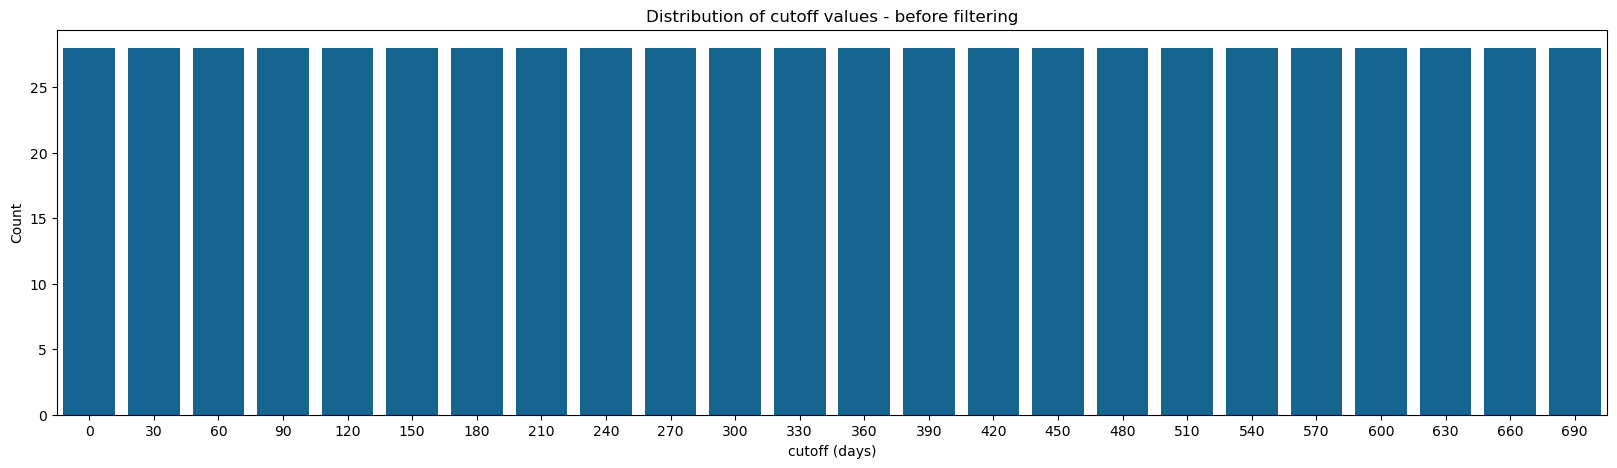

In [6]:
# plot before filtering:
plot_cutoff_date_distribution(c_scores_all, "- before filtering")

# filter scores
if not no_filter:
    # filter: at least one observation must be present before the cutoff
    c_scores_all_f = c_scores_all[c_scores_all["nb_obs_before_cutoff"] > 0].copy()
    # plot after filtering
    plot_cutoff_date_distribution(c_scores_all_f, "- after filtering")
else:
    c_scores_all_f = c_scores_all.copy()

In [7]:
# filter by months_since_cutoff to be in min_ max_samples range
c_scores_subset_f = c_scores_all_f.loc[
    np.logical_and(
        c_scores_all_f["months_since_cutoff"] >= min_samples,
        c_scores_all_f["months_since_cutoff"] <= max_samples,
    ),
    :,
]

# bin scores if not max_resolution
if not max_resolution:
    c_scores_subset_f = c_scores_subset_f.copy()
    # bin months_since_cutoff
    bins = np.arange(min_samples, max_samples + 1.0, 1.0)
    # Use the left edges of the bins as float labels
    labels = bins[:-1]
    c_scores_subset_f.loc[:, "months_since_cutoff"] = pd.cut(
        c_scores_subset_f["months_since_cutoff"], bins=bins, labels=labels, right=False
    )

## Visualize all cutoffs grouped by cutoff value

In [8]:
# all_cutoffs = c_scores_subset_f.use_obs_until_day.unique().tolist()

# for cutoff in all_cutoffs:
#     c_scores_subset_f_ss = c_scores_subset_f[
#         c_scores_subset_f["use_obs_until_day"] == cutoff
#     ].copy()
#     print(cutoff)

#     # avoids having multiple scores per host per bin
#     c_scores_subset_f_ss = select_last_score_per_host_per_bin(c_scores_subset_f_ss)

#     # group samples prior to cutoff if needed - performed here to ensure same
#     # seed sampling independent on group_samples value
#     if group_samples:
#         group_step, last_bin_indicator = _get_step_n_indicator(max_resolution)
#         # uniqueness not based on only host_id here - but also on cutoff_month
#         c_scores_subset_f_ss = _group_samples_prior_to_cutoff(
#             c_scores_subset_f_ss,
#             "months_since_cutoff",
#             ["host_id", "cutoff_month"],
#             min_samples,
#             group_step,
#             last_bin_indicator,
#         )

#     _plot_score_after_nth_abx_exposure(
#         c_scores_subset_f_ss,
#         x_axis="months_since_cutoff",
#         y_axis="score",
#         n=0,
#         path_to_save=evaluation_path,
#         flag=f"noabx_cutoff{int(cutoff)}_scores",
#         tag=f"with cutoff={cutoff}",
#         min_samples=min_samples,
#         max_samples=max_samples,
#         max_resolution=max_resolution,
#         grouped_samples=group_samples,
#     )

## Visualize all cutoffs pooled

Before uniqueness: (3542, 11)
After uniqueness: (3101, 11)
Number of unique cutoffs in subsample: 559
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/reliability_evaluation/gT_maxresF_nc_std_ma10__rd_true/score_after_abx0th_noabx_cutoff_all_scores.pdf


'../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/reliability_evaluation/gT_maxresF_nc_std_ma10__rd_true/score_after_abx0th_noabx_cutoff_all_scores.pdf'

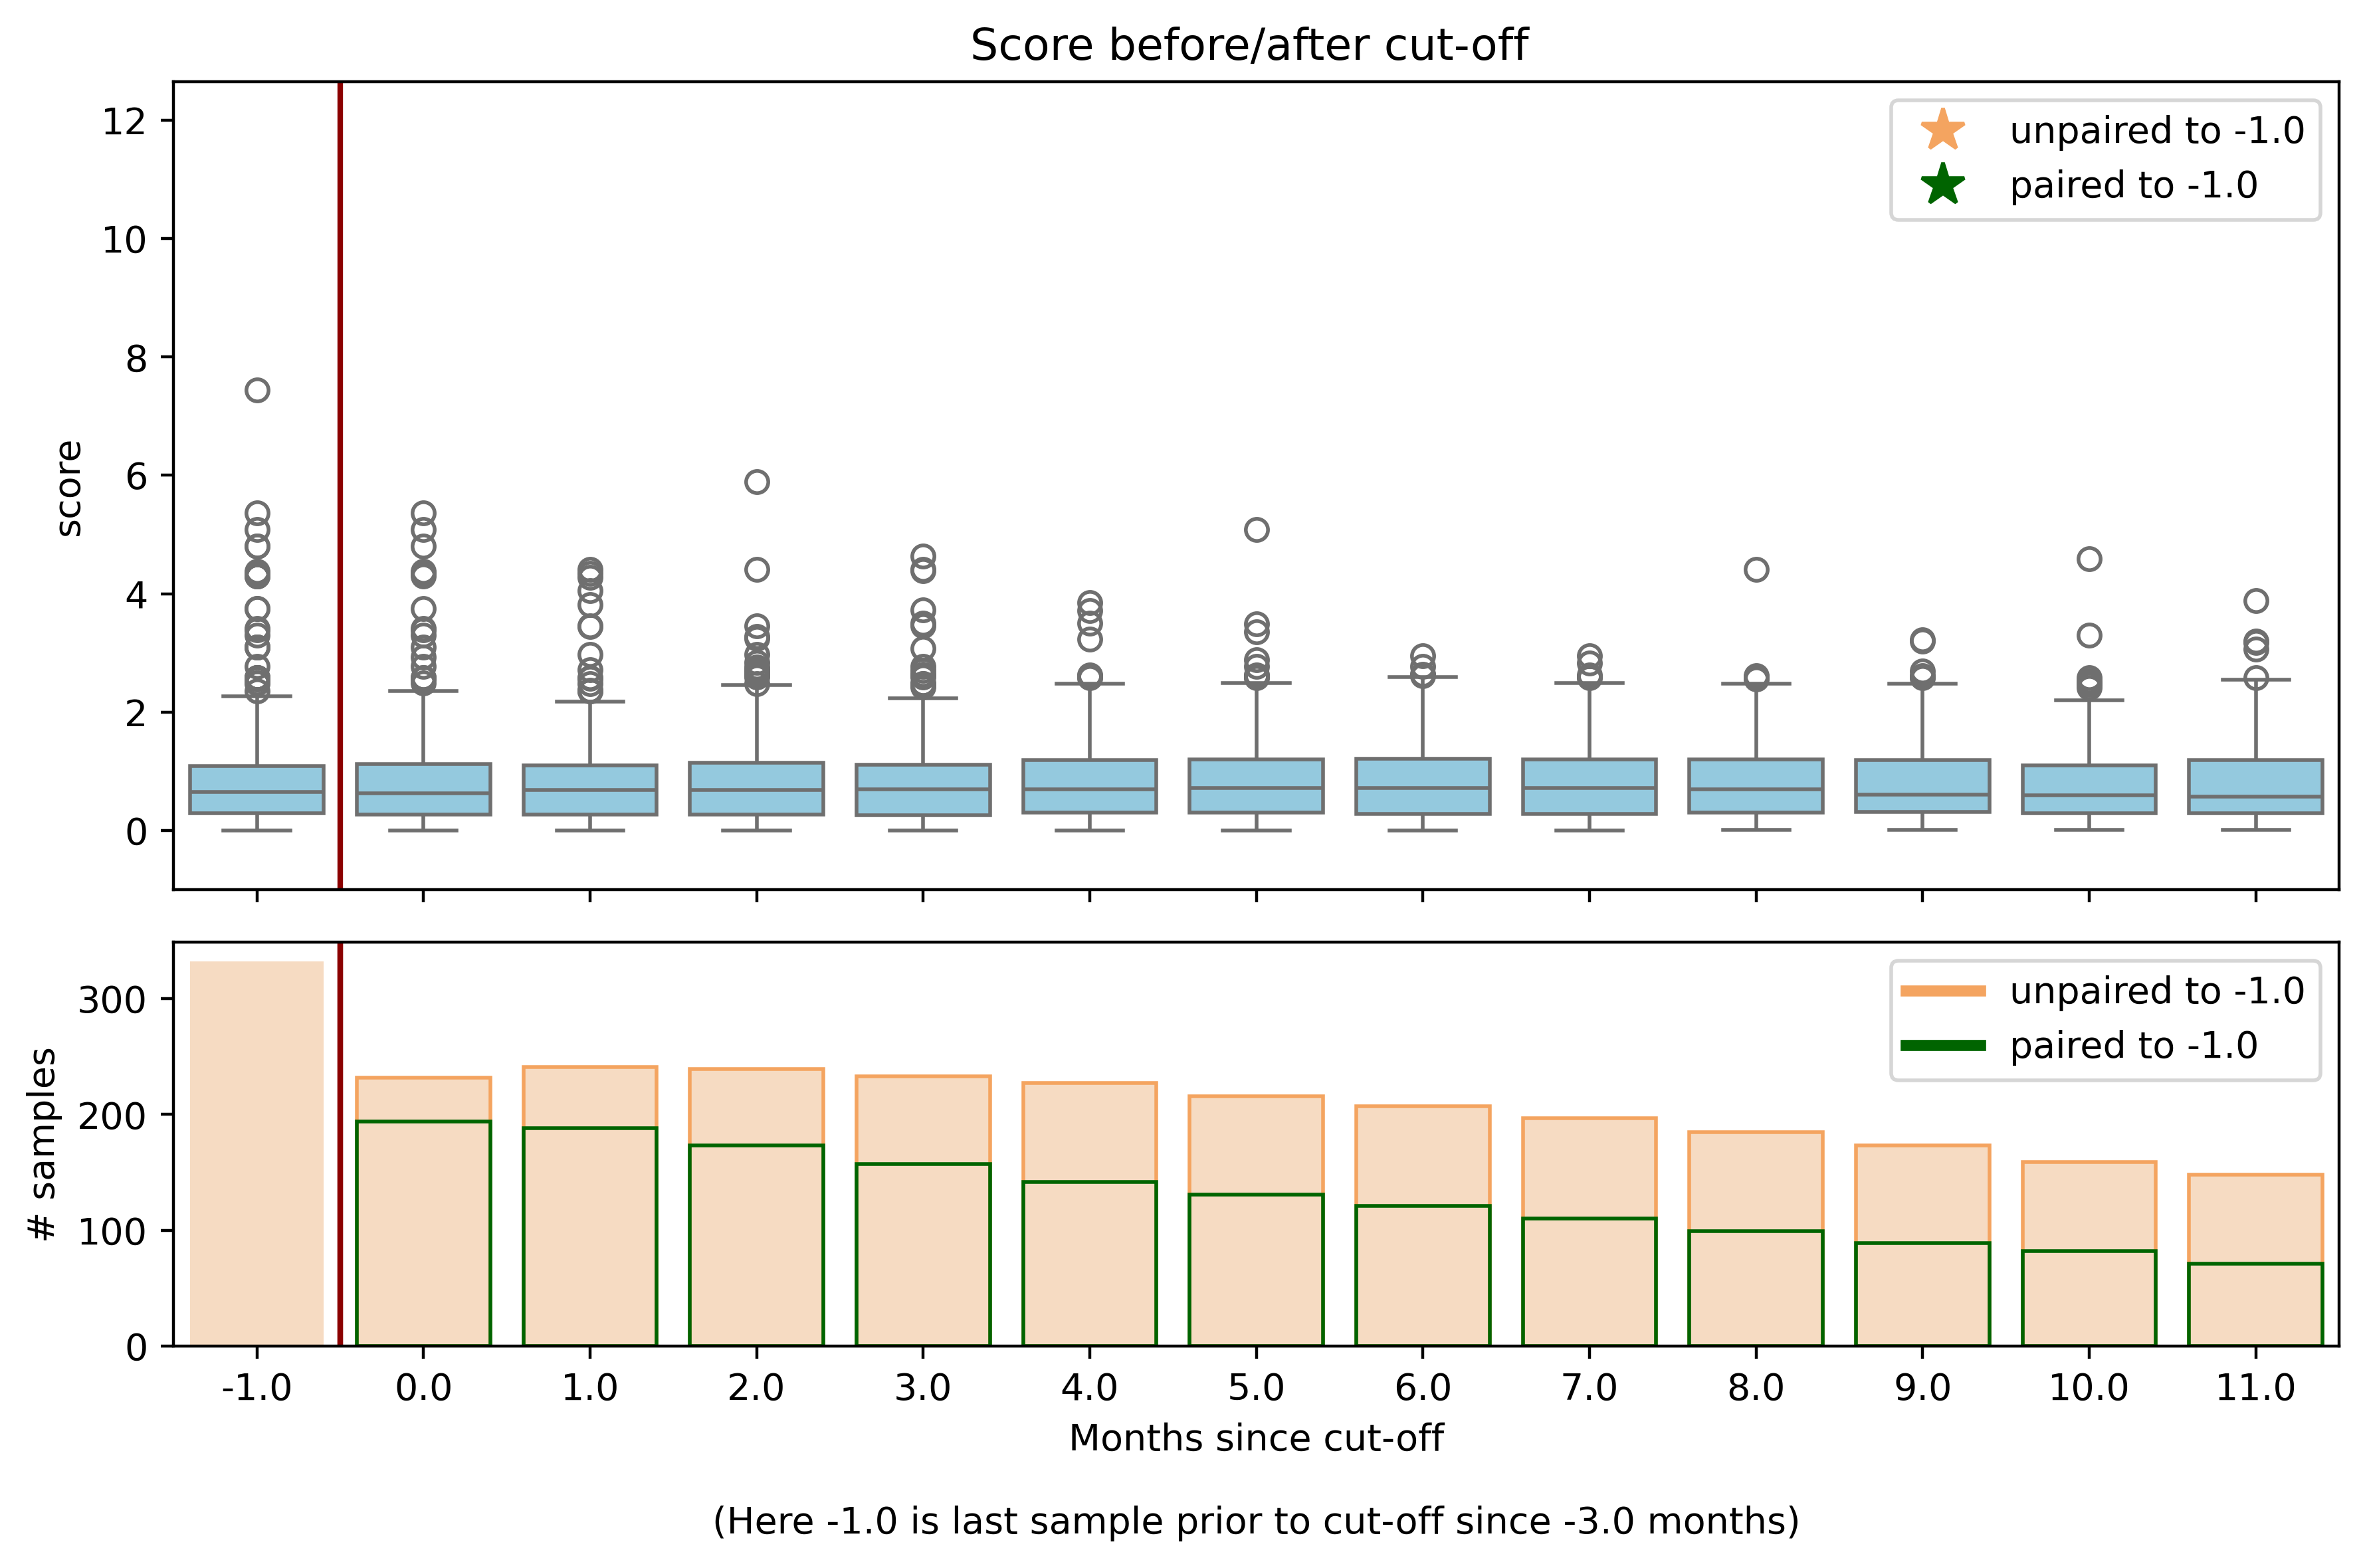

In [9]:
# avoids having multiple scores per host per bin
c_scores_subset_f = select_last_score_per_host_per_bin(c_scores_subset_f)

# group samples prior to cutoff if needed - performed here to ensure same
# seed sampling independent on group_samples value
if group_samples:
    group_step, last_bin_indicator = _get_step_n_indicator(max_resolution)
    # uniqueness not based on only host_id here - but also on cutoff_month
    c_scores_subset_f = _group_samples_prior_to_cutoff(
        c_scores_subset_f,
        "months_since_cutoff",
        ["host_id", "cutoff_month"],
        min_samples,
        group_step,
        last_bin_indicator,
    )


_plot_score_after_nth_abx_exposure(
    c_scores_subset_f,
    x_axis="months_since_cutoff",
    y_axis="score",
    n=0,
    path_to_save=evaluation_path,
    flag="noabx_cutoff_all_scores",
    tag="",
    min_samples=min_samples,
    max_samples=max_samples,
    max_resolution=max_resolution,
    grouped_samples=group_samples,
    uniqueness_var_ls=["use_obs_until_day"],
)


## Visualize cutoffs - same "cutoff" subset as for 1st/2nd/3rd abx scores

In [10]:
# set max_samples to 6 for consistency with abx comparison in evaluate_scores
max_samples = 6.0

# filter by months_since_cutoff to be in min_ max_samples range
c_scores_subset_f = c_scores_all_f.loc[
    np.logical_and(
        c_scores_all_f["months_since_cutoff"] >= min_samples,
        c_scores_all_f["months_since_cutoff"] <= max_samples,
    ),
    :,
]

# bin scores if not max_resolution
if not max_resolution:
    c_scores_subset_f = c_scores_subset_f.copy()
    # bin months_since_cutoff
    bins = np.arange(min_samples, max_samples + 1.0, 1.0)
    # Use the left edges of the bins as float labels
    labels = bins[:-1]
    c_scores_subset_f.loc[:, "months_since_cutoff"] = pd.cut(
        c_scores_subset_f["months_since_cutoff"], bins=bins, labels=labels, right=False
    )

Number of cutoffs in abx: 37
Number of cutoffs in subsample: 37


/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_24197/4047365188.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


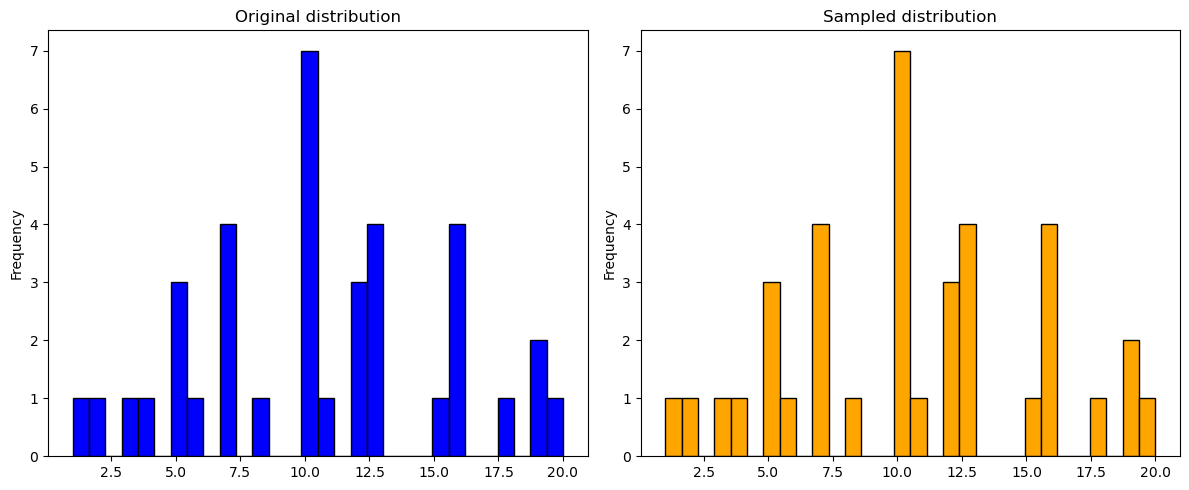

UNIQUE HOSTS selected ['E032966' 'P017255' 'P000756' 'E020570' 'P014839' 'P021343' 'T008631'
 'E007944' 'P016497' 'P020861' 'T003745' 'P020631' 'P019854' 'P021772']
Before uniqueness: (235, 11)
After uniqueness: (183, 11)
Number of unique cutoffs in subsample: 37
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/reliability_evaluation/gT_maxresF_nc_std_ma10__rd_true/score_after_abx0th_noabx_1matched_scores.pdf
Number of cutoffs in abx: 32
Number of cutoffs in subsample: 32


/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_24197/4047365188.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


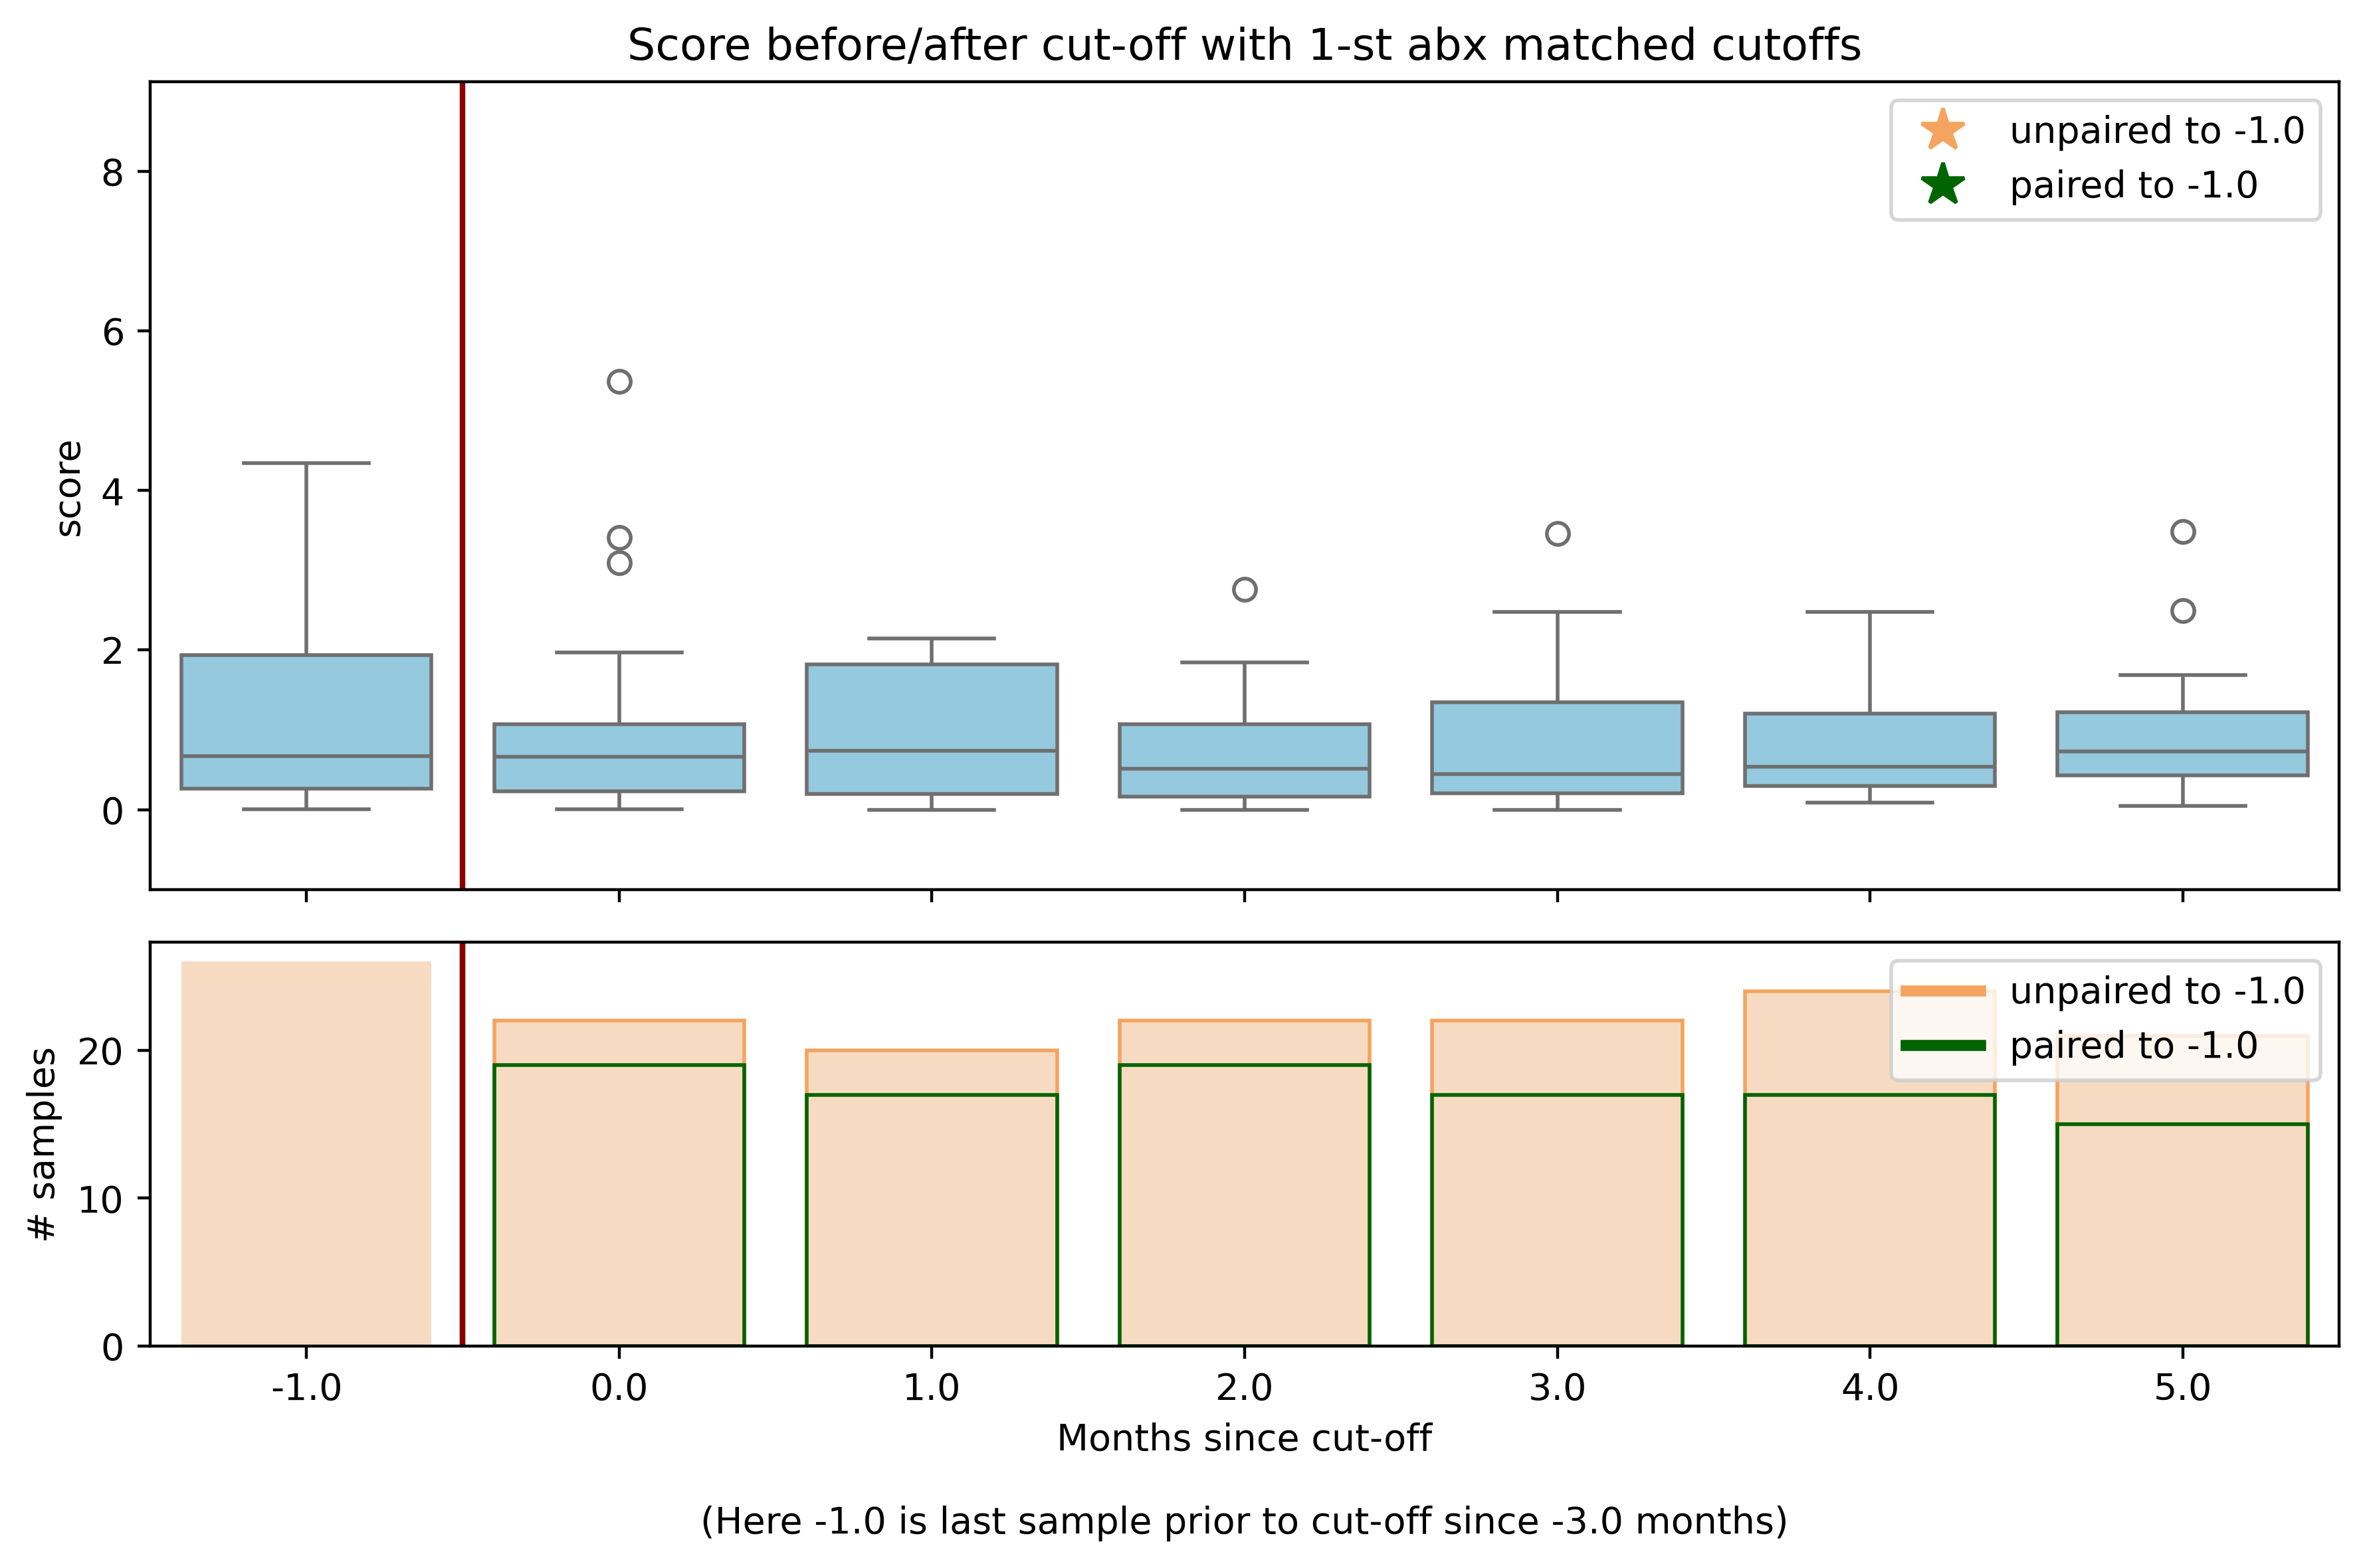

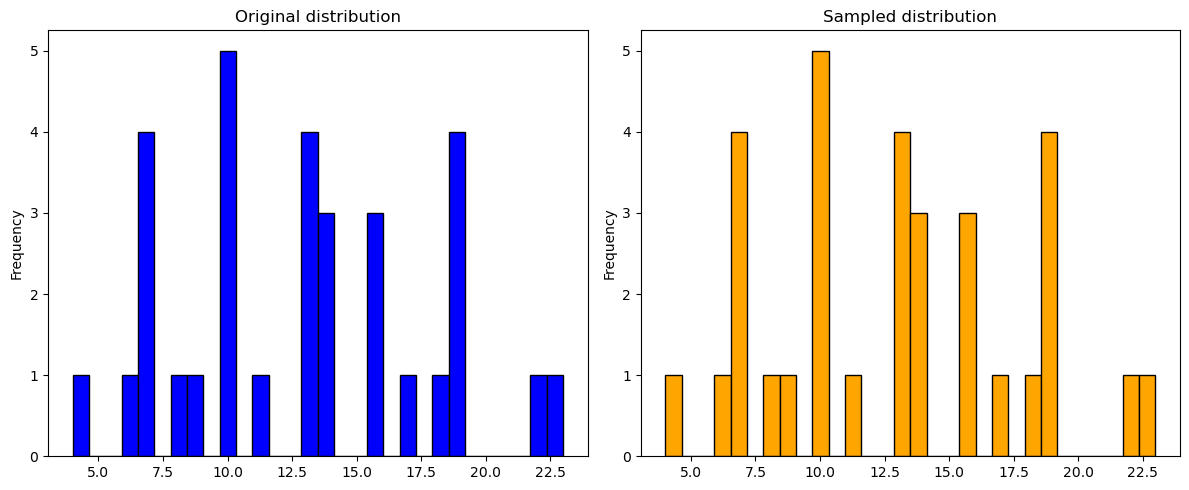

UNIQUE HOSTS selected ['P000756' 'E032966' 'E020570' 'P014839' 'P021343' 'T008631' 'E007944'
 'P020861' 'T003745' 'P019854' 'P017255' 'P008579' 'P021772' 'T003950'
 'T003355']
Before uniqueness: (181, 11)
After uniqueness: (147, 11)
Number of unique cutoffs in subsample: 32
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/reliability_evaluation/gT_maxresF_nc_std_ma10__rd_true/score_after_abx0th_noabx_2matched_scores.pdf
Number of cutoffs in abx: 22
Number of cutoffs in subsample: 22


/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_24197/4047365188.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


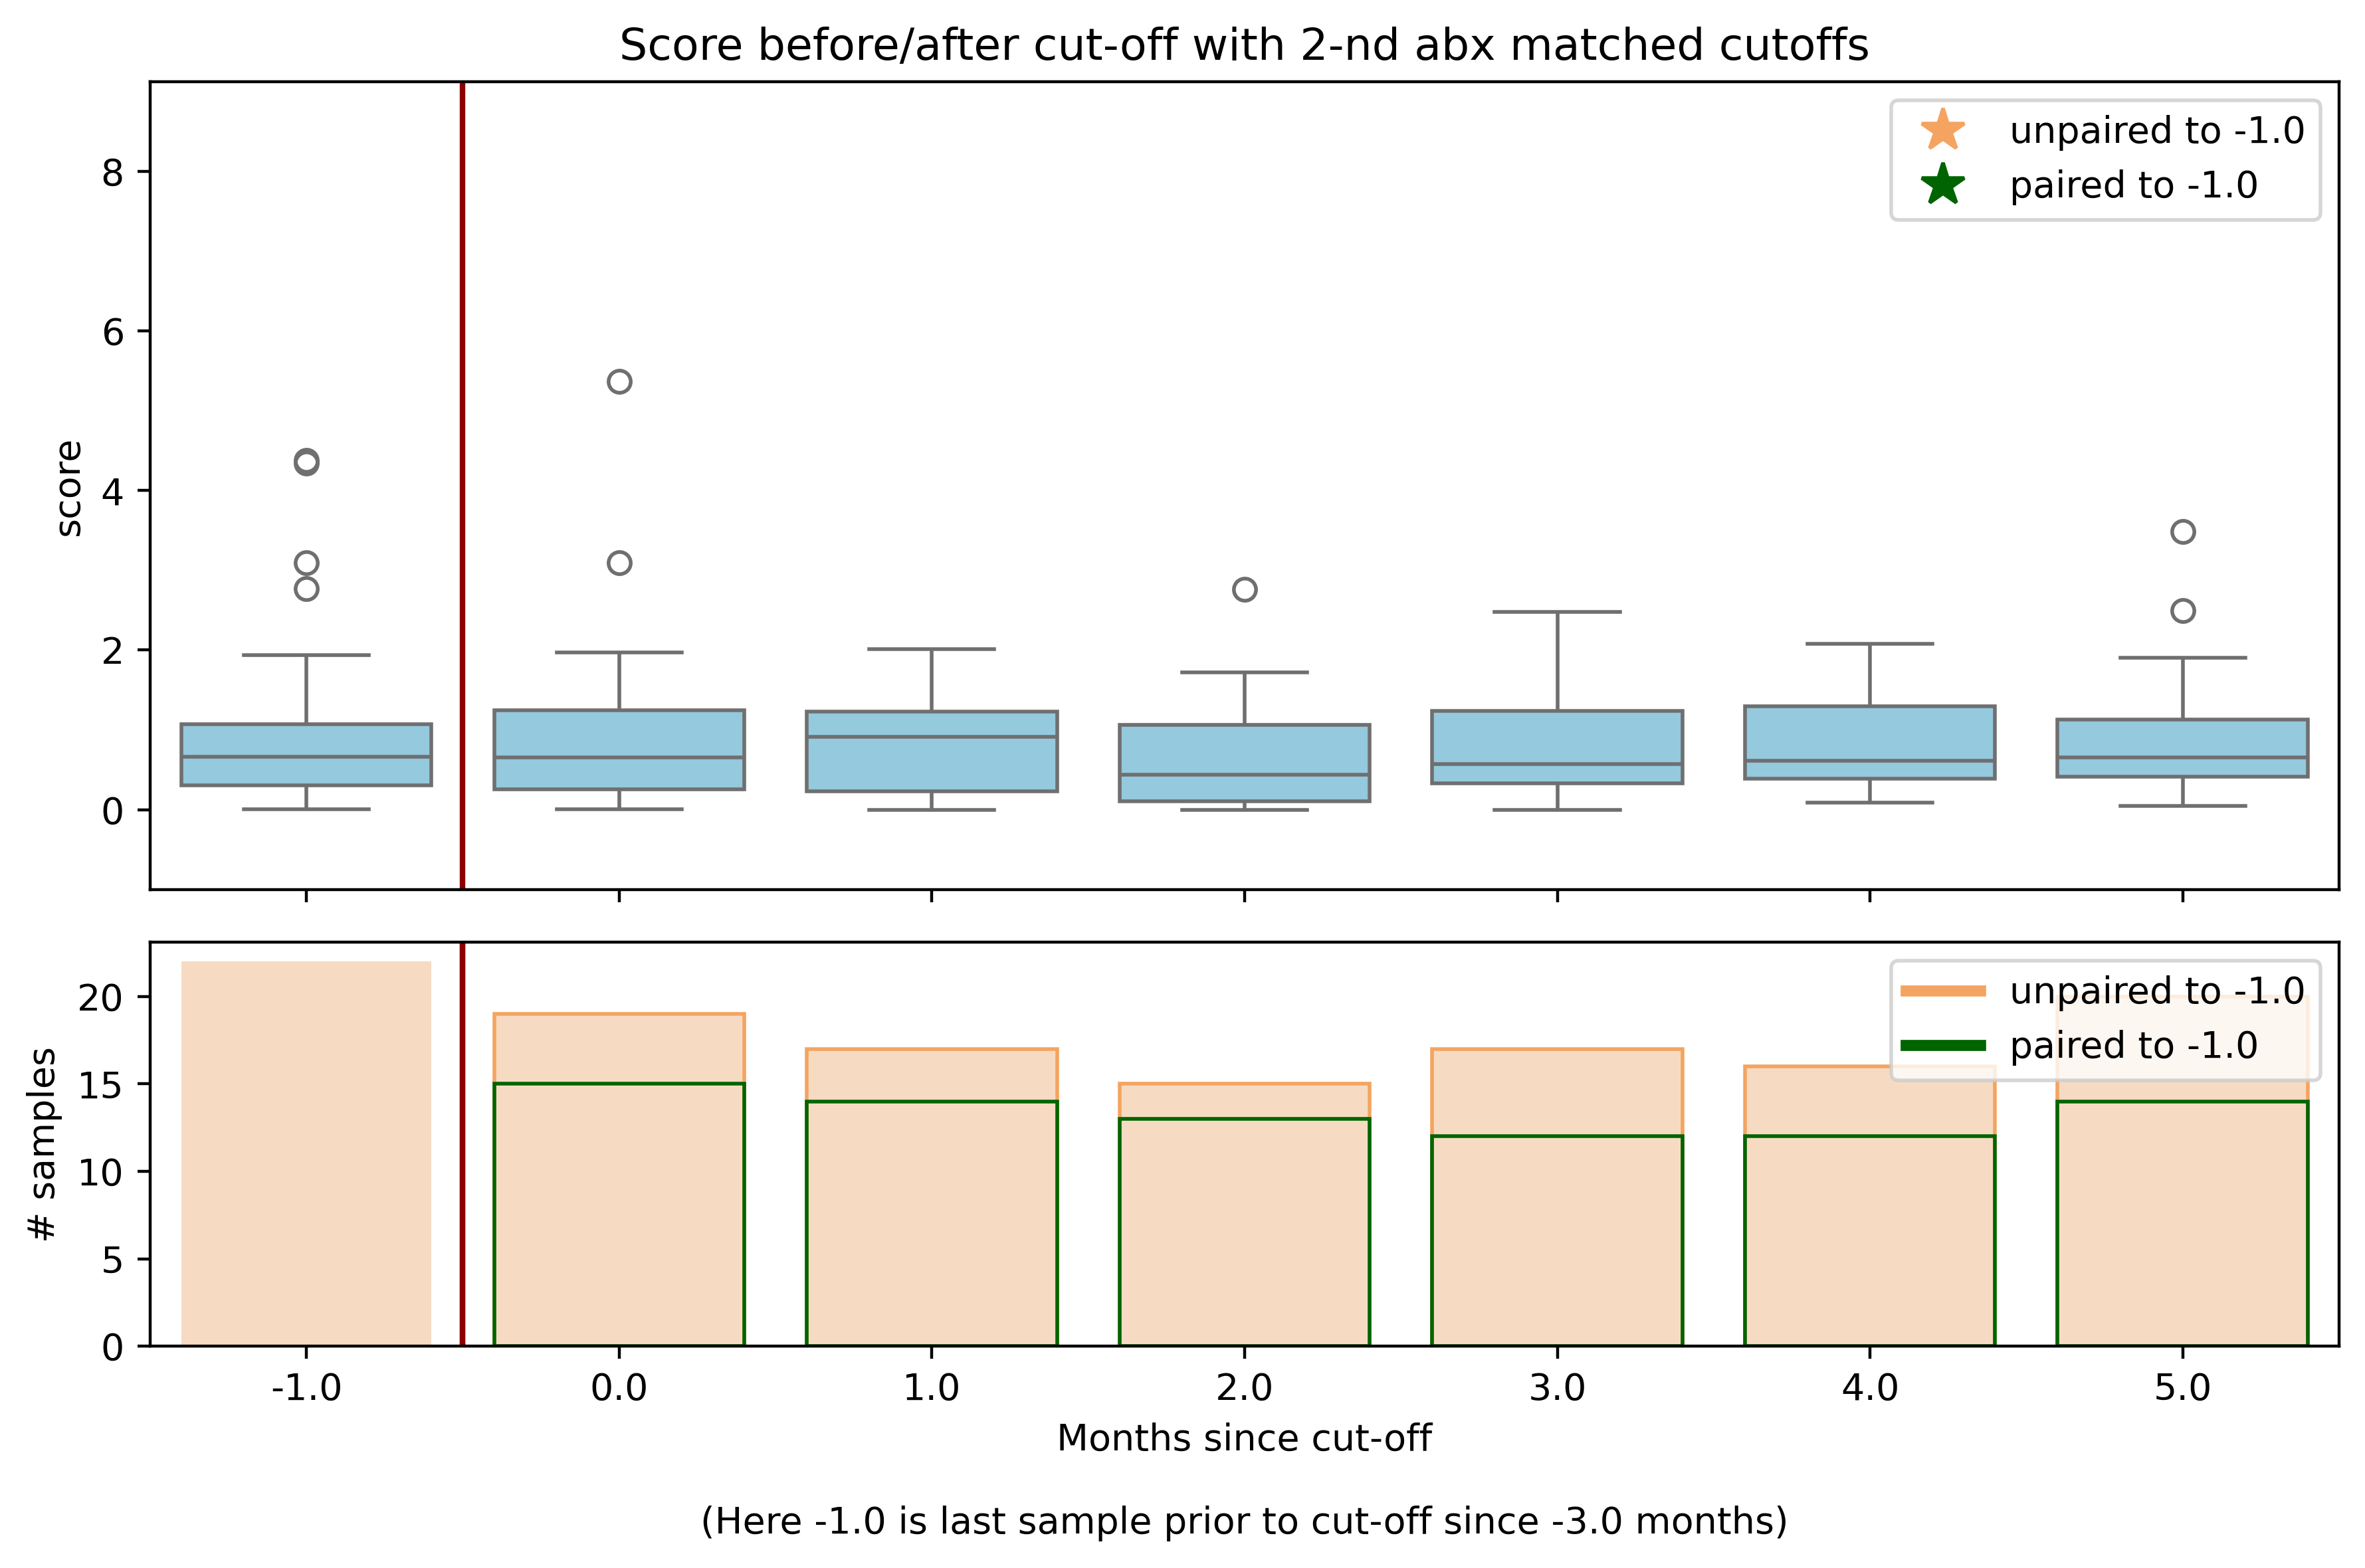

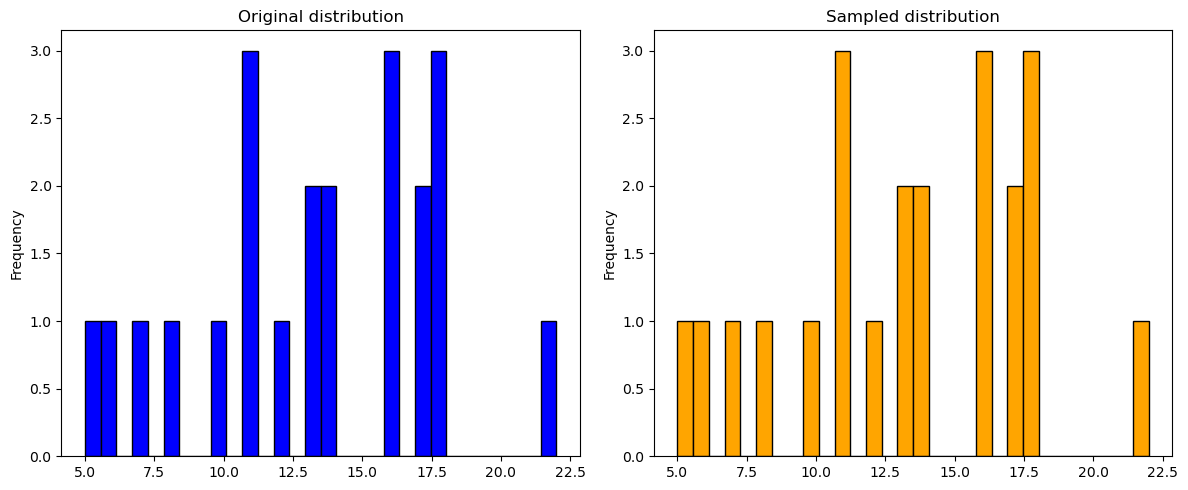

UNIQUE HOSTS selected ['E032966' 'P021343' 'P020861' 'E020570' 'P014839' 'P020631' 'P000756'
 'P017255' 'P008579' 'P019854' 'P021772' 'T003950' 'T003355']
Before uniqueness: (118, 11)
After uniqueness: (90, 11)
Number of unique cutoffs in subsample: 22
Saving plot to ../data/saved_models_microbial_novel_alpha_div2/id-57/anomaly_detection/reliability_evaluation/gT_maxresF_nc_std_ma10__rd_true/score_after_abx0th_noabx_3matched_scores.pdf


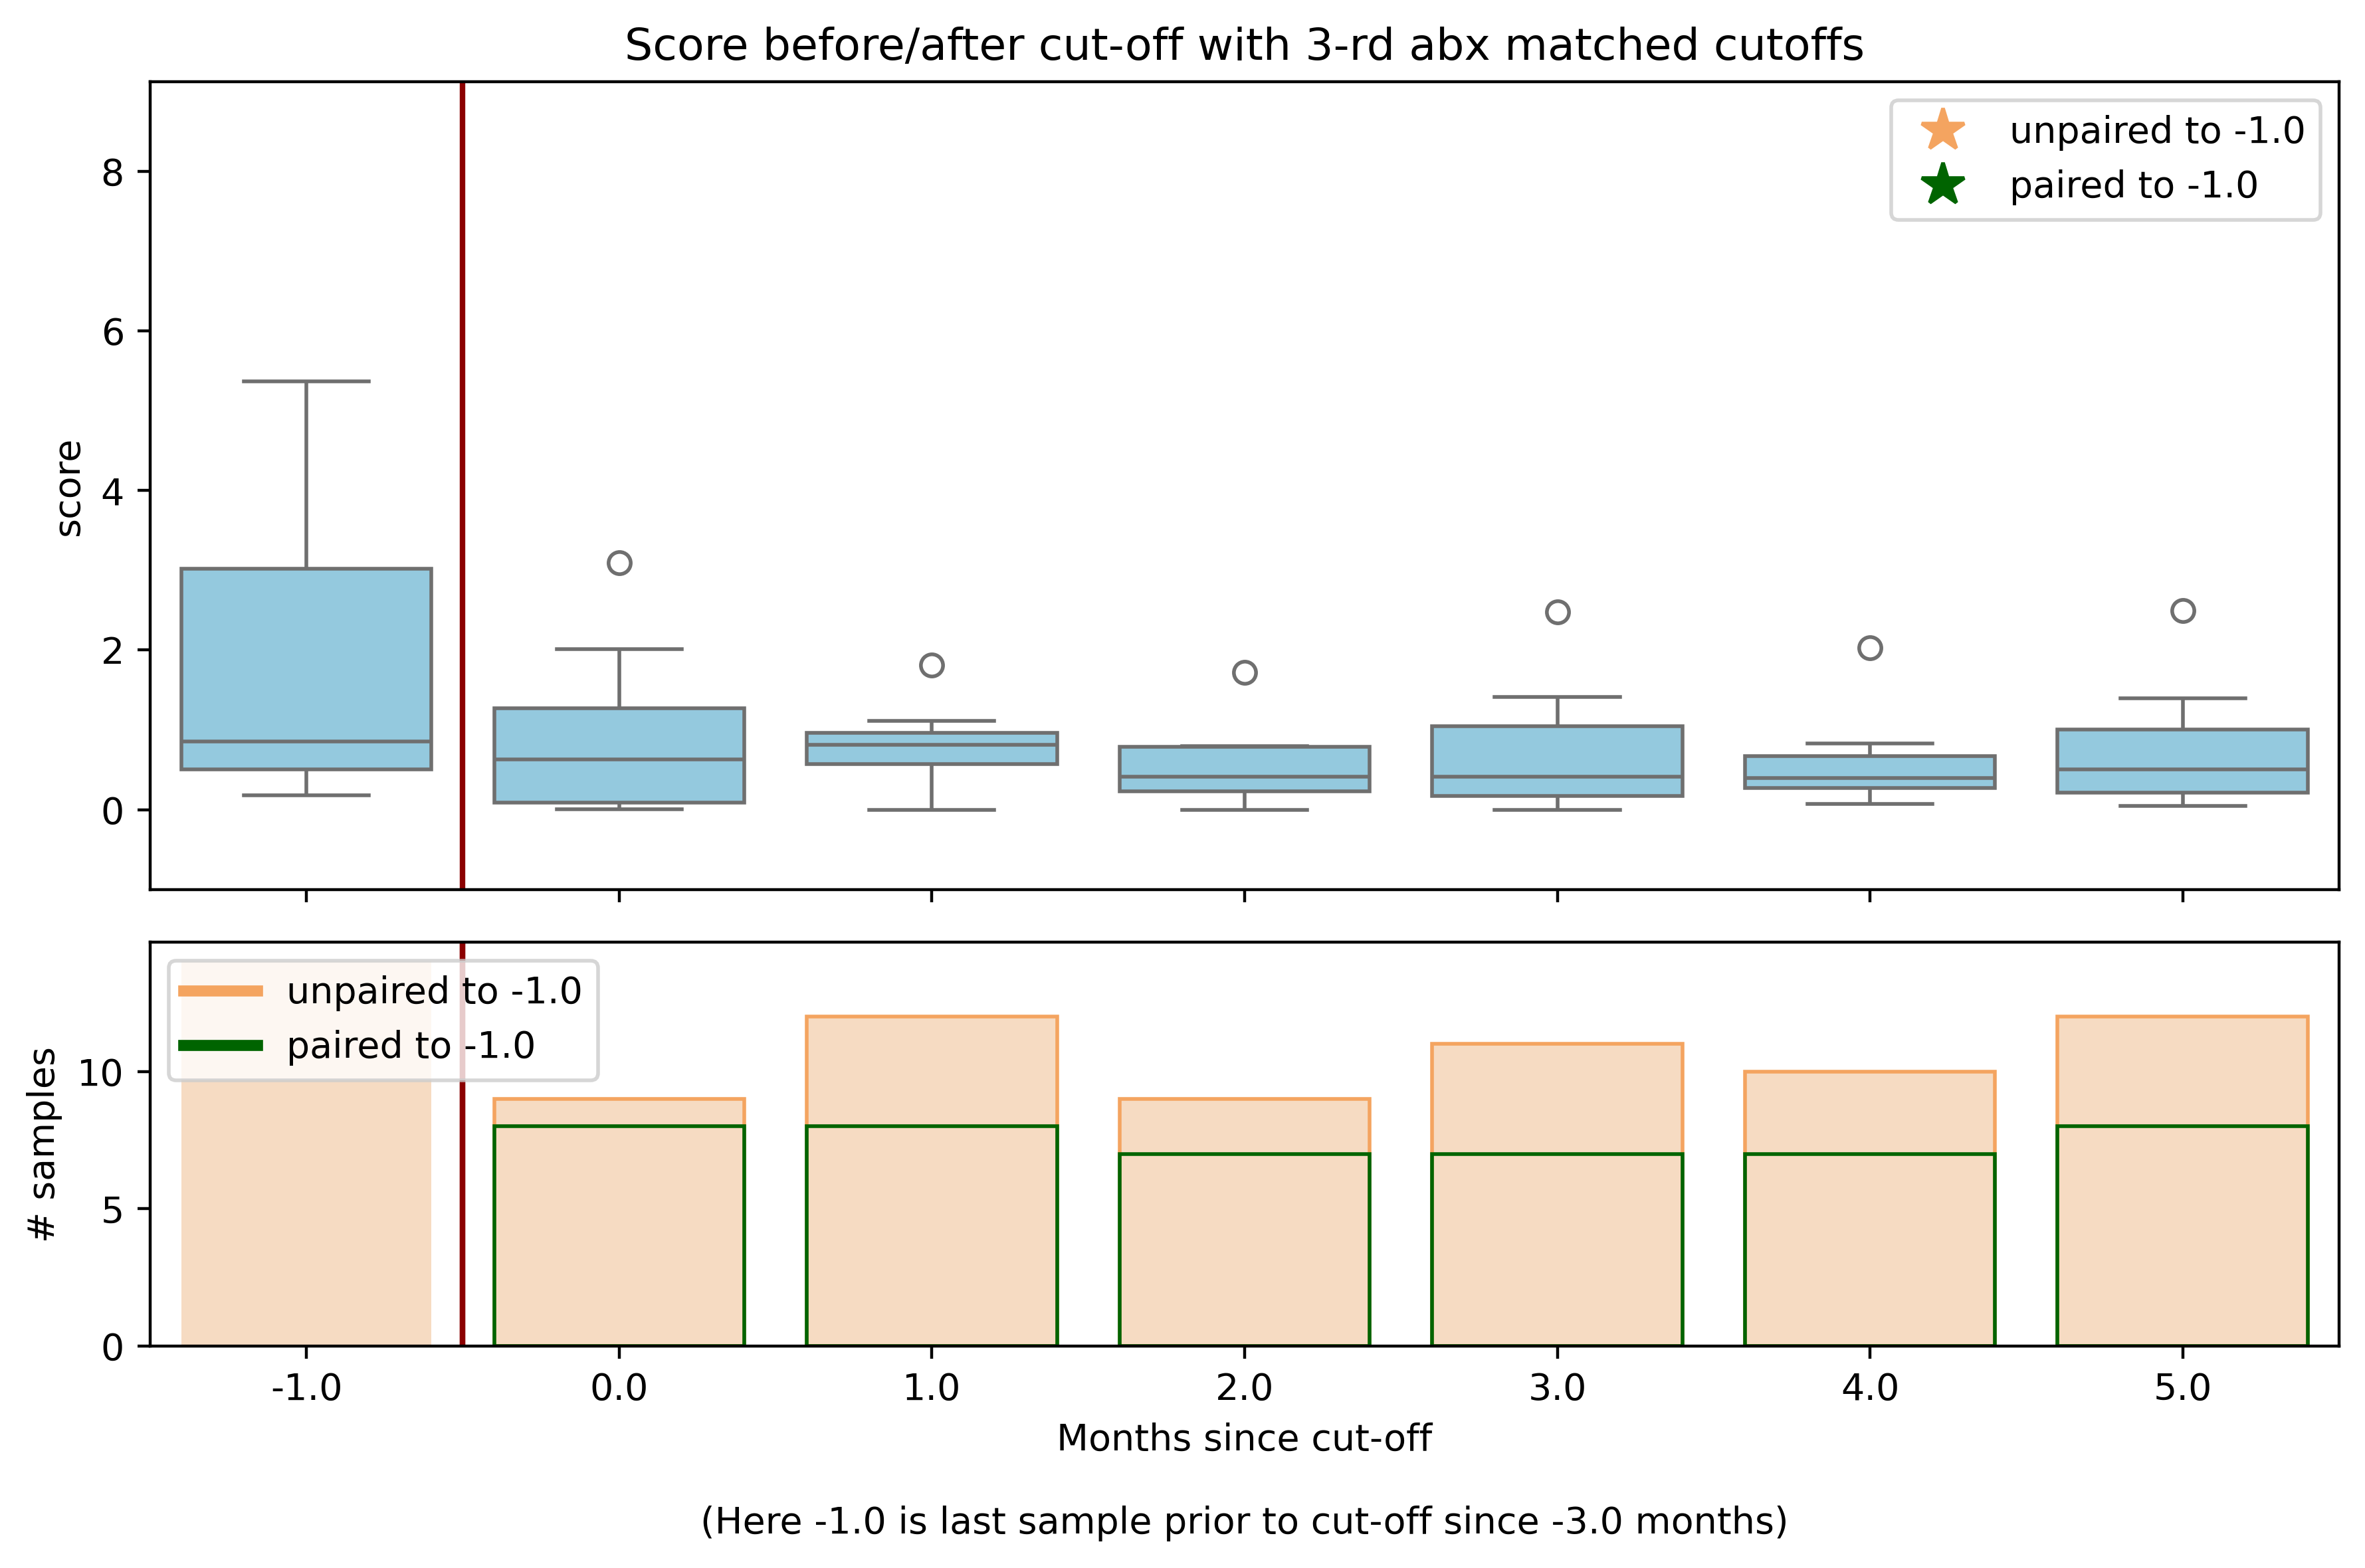

In [11]:
# get all host's cutoffs to choose from

# # to only take hosts that have a value after cutoff
# c_scores_subset_f_f = c_scores_subset_f[c_scores_subset_f["months_since_cutoff"]==0.0].copy()
# cutoff_host_mapping = c_scores_subset_f_f[["host_id", "cutoff_month"]].drop_duplicates()
# otw:
cutoff_host_mapping = c_scores_subset_f[["host_id", "cutoff_month"]].drop_duplicates()

for n in [1, 2, 3]:
    cutoff_values, sample_sizes = get_cutoff_value_sample_sizes(
        abx_scores_flat, abx_df, n, min_samples, max_samples, group_samples
    )
    print(f"Number of cutoffs in abx: {sum(sample_sizes.values())}")

    # subsample in cutoff_host_mapping by sample_sizes:
    cutoff_host_mapping_subset = (
        cutoff_host_mapping.groupby("cutoff_month", group_keys=False)
        .apply(
            sample_from_each_group,
            sample_sizes=sample_sizes,
            seed=8,
            include_groups=True,
        )
        .reset_index(drop=True)
    )
    print(f"Number of cutoffs in subsample: {cutoff_host_mapping_subset.shape[0]}")

    # VERIFY distributions: Now, cutoff_host_mapping_subset has the same
    # cutoff_month distribution as in cutoff_values
    display_two_distributions(
        orig_values=cutoff_values,
        sampled_values=cutoff_host_mapping_subset["cutoff_month"].values,
    )

    # get only scores from cutoff_host_mapping_subset to plot
    sampled_subset_nth = pd.merge(
        c_scores_subset_f,
        cutoff_host_mapping_subset[["host_id", "cutoff_month"]],
        on=["host_id", "cutoff_month"],
        how="inner",
    )
    assert (
        sampled_subset_nth.host_id.nunique()
        == cutoff_host_mapping_subset.host_id.nunique()
    )
    print(f"UNIQUE HOSTS selected {sampled_subset_nth.host_id.unique()}")

    # if there are multiple scores per months_since_cutoff bin per host - take last
    # avoids having multiple scores per host per bin
    sampled_subset_nth = select_last_score_per_host_per_bin(sampled_subset_nth)

    # group samples prior to cutoff if needed - performed here to ensure same
    # seed sampling independent on group_samples value
    if group_samples:
        group_step, last_bin_indicator = _get_step_n_indicator(max_resolution)
        # uniqueness not based on only host_id here - but also on cutoff_month
        sampled_subset_nth = _group_samples_prior_to_cutoff(
            sampled_subset_nth,
            "months_since_cutoff",
            ["host_id", "cutoff_month"],
            min_samples,
            group_step,
            last_bin_indicator,
        )
    else:
        last_bin_indicator = min_samples

    assert sampled_subset_nth.months_since_cutoff.min() == last_bin_indicator

    # plot
    _plot_score_after_nth_abx_exposure(
        sampled_subset_nth,
        x_axis="months_since_cutoff",
        y_axis="score",
        n=0,
        path_to_save=evaluation_path,
        flag=f"noabx_{n}matched_scores",
        tag=f"with {n}-{_get_ordinal_suffix(n)} abx matched cutoffs",
        min_samples=min_samples,
        max_samples=max_samples,
        max_resolution=max_resolution,
        grouped_samples=group_samples,
        uniqueness_var_ls=["use_obs_until_day"],
    )
